In [4]:
from pyspark import SparkContext, SparkConf
from pyspark.sql import SparkSession

sc_conf = SparkConf() \
    .setAppName('ProductData') \
    .setMaster('local[*]') \
    .set('spark.executor.cores', '3') \
    .set('spark.executor.memory', '1536m') \
    .set('spark.driver.cores', '1') \
    .set('spark.driver.memory', '1536m') \
    .set('spark.python.worker.memory', '1g')
sc = SparkContext(conf=sc_conf)
spark = SparkSession(sc)


In [5]:
# PART 1: Read each file and create RDD consisting of lines
google_file = "./data/Google.csv"
google_df = spark.read.csv(google_file, header = True, inferSchema = True)
amazon_file = "./data/Amazon.csv"
amazon_df = spark.read.csv(amazon_file, header = True, inferSchema = True)
amazon_df.show(n = 2)

+----------+--------------------+--------------------+-------------------+-----+
|        id|               title|         description|       manufacturer|price|
+----------+--------------------+--------------------+-------------------+-----+
|b000jz4hqo|clickart 950 000 ...|                null|         broderbund|  0.0|
|b0006zf55o|ca international ...|oem arcserve back...|computer associates|  0.0|
+----------+--------------------+--------------------+-------------------+-----+
only showing top 2 rows



In [6]:
# PART 2: Remove stopwords, tokenize with regex
from pyspark.ml.feature import RegexTokenizer, StopWordsRemover

# substitute empty string for NULL so transforms don't fail
amazon_df = amazon_df.fillna('')
google_df = google_df.fillna('')

# tokenize the description strings, separating on whitespace
regex = RegexTokenizer(inputCol = "description", outputCol = "tokens", pattern="\\W")
amz_tokens = regex.transform(amazon_df)
ggl_tokens = regex.transform(google_df)
amz_tokens.show(n = 2)


+----------+--------------------+--------------------+-------------------+-----+--------------------+
|        id|               title|         description|       manufacturer|price|              tokens|
+----------+--------------------+--------------------+-------------------+-----+--------------------+
|b000jz4hqo|clickart 950 000 ...|                    |         broderbund|  0.0|                  []|
|b0006zf55o|ca international ...|oem arcserve back...|computer associates|  0.0|[oem, arcserve, b...|
+----------+--------------------+--------------------+-------------------+-----+--------------------+
only showing top 2 rows



In [7]:
# REMOVE STOP WORDS
# get the stopwords list - this is horribly inefficient, but it's the only way I can get Spark
# to pick up the file from the Databricks environment
sw_file = "./data/stopwords.txt"
stopwords_rdd = sc.parallelize(sw_file)
stopwords_list = stopwords_rdd.collect()
# create and use the stop words filter
stopword_filter = StopWordsRemover(inputCol = "tokens", outputCol = "filtered", stopWords = stopwords_list)
ggl_filtered = stopword_filter.transform(ggl_tokens)
amz_filtered = stopword_filter.transform(amz_tokens)
amz_filtered.show(n = 2)


+----------+--------------------+--------------------+-------------------+-----+--------------------+--------------------+
|        id|               title|         description|       manufacturer|price|              tokens|            filtered|
+----------+--------------------+--------------------+-------------------+-----+--------------------+--------------------+
|b000jz4hqo|clickart 950 000 ...|                    |         broderbund|  0.0|                  []|                  []|
|b0006zf55o|ca international ...|oem arcserve back...|computer associates|  0.0|[oem, arcserve, b...|[oem, arcserve, b...|
+----------+--------------------+--------------------+-------------------+-----+--------------------+--------------------+
only showing top 2 rows



In [8]:
# PART 3: Write a function that takes a list of tokens and returns a dictionary mapping tokens to term frequency
from pyspark.sql import Row

def make_term_freq_dict(tokens, normalize = True):
  '''
  Returns a dictionary mapping term in a collection of tokens to its *normalized* frequency
  '''
  d = {}
  if normalize:
    normalization_factor = len(tokens)
  else:
    normalization_factor = 1.0
  for tok in tokens:
    if not tok in d:
      d[tok] = 1./normalization_factor
    else:d[tok] += 1./normalization_factor
  return d   

def term_freq(df, tokensColumn, mapColumn, normalize = True):
  '''
  Returns a Spark dataframe with a map of token to normalized count in the (new) designated column.
  
  Parameters:
  df - pyspark.DataFrame instance
  tokensColumn - name of column containing the tokens to be counted
  mapColumn - name of column to which normalized term-frequency map will be written for each row
  '''
  newColumnList = df.columns + [mapColumn]
  new_rdd = df.rdd.map(lambda row: (row + Row(make_term_freq_dict(row[tokensColumn], normalize))))
  return new_rdd.toDF(newColumnList)


In [9]:
# test term_freq function
counted = term_freq(amz_filtered, "filtered", "tf", False)
counted.select('tf').show(n = 10, truncate = 120)


+------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                      tf|
+------------------------------------------------------------------------------------------------------------------------+
|                                                                                                                      []|
|[1 -> 1.0, arcserve -> 1.0, backup -> 1.0, desktops -> 1.0, and -> 1.0, oem -> 1.0, v11 -> 1.0, for -> 1.0, 30u -> 1....|
|                                                                                                                      []|
|[year -> 1.0, advanced -> 1.0, striving -> 1.0, backed -> 1.0, costing -> 1.0, convert -> 1.0, your -> 5.0, billing -...|
|[singing -> 1.0, nt -> 1.0, unlimited -> 1.0, xp -> 1.0, me -> 1.0, electronic -> 1.0, 2000 -> 1.0, learning -> 1.0, ...|
|               

In [10]:
# PART 4: combine the two filtered dataframes into a single "corpus"
combined = ggl_filtered.select('id', 'filtered').union(amz_filtered.select('id','filtered'))

In [26]:
# PART 5: An IDF function that returns a pair RDD having key = token and value = IDF. 
from pyspark.ml.feature import CountVectorizer, IDF

def token_idf_pair_rdd(df, tokenCol):
  '''
  Calculates IDF for all tokens in designated column; 
  returns a pair RDD with token as key and IDF as value
  '''
  # The counter is binary per document-word because that is the simplest method of calculation
  counter = CountVectorizer(binary = True, inputCol = tokenCol, outputCol = 'counted')
  count_model = counter.fit(df)
  counted = count_model.transform(df)
  idfer = IDF(inputCol = 'counted', outputCol = 'idf')
  idf_model = idfer.fit(counted)
  tf_idf = idf_model.transform(counted)
  data = [(count_model.vocabulary[i], float(idf_model.idf[i])) for i in range(len(count_model.vocabulary))]
  return sc.parallelize(data)


In [12]:
# Verify that the function works
idf_map_rdd = token_idf_pair_rdd(combined, 'filtered')
idf_map_rdd.take(5)

[('and', 0.47972392120040291),
 ('the', 0.57338112086856174),
 ('to', 0.71606576853438264),
 ('of', 0.8653242882821276),
 ('your', 1.0658224658451187)]

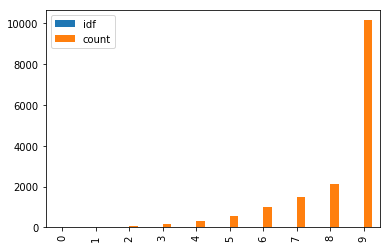

In [47]:
# Histogram of IDF values
import pandas as pd
%matplotlib inline

idf_hist = idf_map_rdd.map(lambda x: x[1]).histogram(10)
idf_hist_list = list(zip(*idf_hist))
pd_hist = pd.DataFrame(idf_hist_list, columns = ["idf", "count"])
pd_hist.set_index('idf')
pd_hist.plot(kind='bar')


In [38]:
# PART 6: Write a function which does the following on entire corpus:
# (a) Calculate term frequencies (not normalized) for tokens
# (b) Create a DataFrame where each token maps to the token's frequency times the token's IDF weight
import pyspark.sql.functions as func
from pyspark.sql.types import StructField, StructType, DoubleType, StringType

def word_count_df(df, tokenCol, wordColumnName = 'word', countColumnName = 'count'):
  '''
  Returns a dataframe with 2 columns:
    * keyColumnName - tokens
    * valueColumnName - count of token aggregated over all rows in df
  '''
  # Note that the counts are *not* normalized per-document
  df_mapped = term_freq(df, tokenCol, 'tf', normalize = False)
  df_word_count = df_mapped.select(func.explode('tf'))
  df_word_count = df_word_count.groupby('key').agg(func.sum('value').alias(countColumnName))
  return df_word_count.withColumnRenamed('key', wordColumnName)
  
def tf_idf_over_corpus(df, tokenCol):
  '''
  Returns a dataframe with two columns:
  * "word": string - unique token
  * "tfidf": float - count-in-corpus times idf
  Also returns a pair RDD with 1st column/key = token and 2d col/value = IDF 
  
  Parameters:
  df - DataFrame
  tokenCol:string - name of column containing tokens
  '''
  # drop all the columns except for the tokens column
  columnList = df.columns
  columnList.remove(tokenCol)
  for c in columnList:
    df = df.drop(c)
    
  # get an idf pair rdd (word -> idf)
  idf_rdd = token_idf_pair_rdd(df, tokenCol)
  df_idf_schema = StructType([
    StructField("word", StringType()),
    StructField("idf", DoubleType())
  ])
  df_idf = spark.createDataFrame(idf_rdd, df_idf_schema)
  
  # get a dataframe with two columns, 'word' and 'count'
  df_wc = word_count_df(df, tokenCol, wordColumnName = 'word', countColumnName = 'count')
  df_wc.drop(tokenCol)
  
  # join on the 'word' column
  df_wc_idf = df_wc.join(df_idf, on = 'word')
  
  # do the multiplication to yield the tf-idf
  return df_wc_idf.withColumn('tfidf', func.col('count') * func.col('idf')).drop('count').drop('idf'), idf_rdd


In [40]:
# test the tf_idf_over_corpus function, which returns 
# (1) a DF with columns 'word' and 'tfidf'
# (2) a pair RDD with key = token and value = IDF

from itertools import chain
from pyspark.sql.functions import col, create_map

df_tfidf, _ = tf_idf_over_corpus(combined, 'filtered')

# Let's transform the data to a mapped format, with a single column that maps word->tfidf
map_column = create_map(list(chain((col('word'), col('tfidf'))))).alias('map')
df_map = df_tfidf.select(map_column)

# Let's take a peek at the map dataframe
print(df_tfidf.schema)
print(df_tfidf.columns)
print(df_map.schema)
print(df_map.columns)

# Save to a file in json format 
dfmap_file = "./data/d.json"
df_map.write.json(dfmap_file)


StructType(List(StructField(word,StringType,false),StructField(tfidf,DoubleType,true)))
['word', 'tfidf']
StructType(List(StructField(map,MapType(StringType,DoubleType,true),false)))
['map']
